In [1]:
import numpy as np
import poke.poke_core as pol
import poke.plotting as plt
from astropy.io import fits
import astropy.units as u
import poppy


In [2]:
pth = 'Subaru_M1-M3_750nm.fits'

jones_pupil = fits.open(pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1] 
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1] 

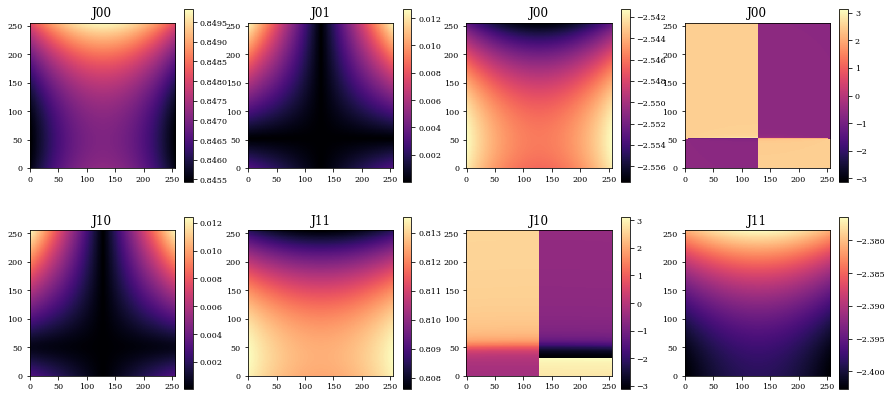

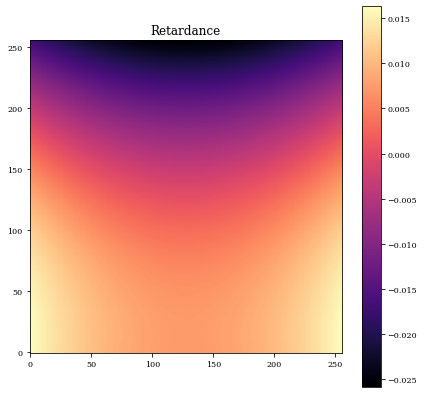

In [10]:
plt.PlotJonesArray(J11,J12,J21,J22)

ret = np.angle(J11)-np.angle(J22)
ret -= np.mean(ret)

plot.figure(figsize=[7,7])
plot.title('Retardance')
plot.imshow(ret)
plot.colorbar()
plot.show()

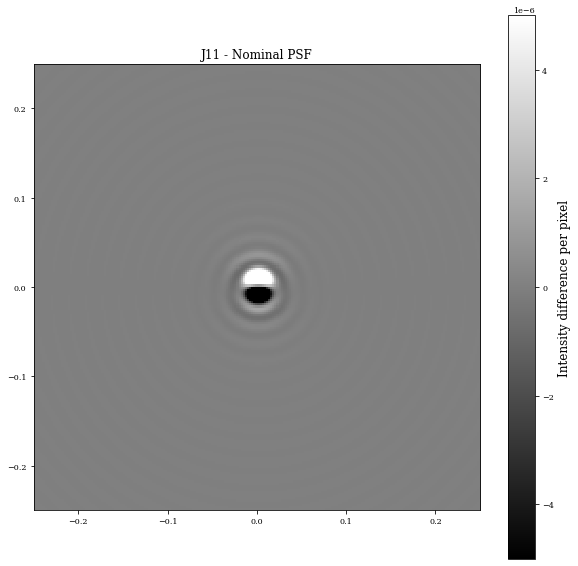

In [4]:
# Define some input linear polarization state
E = np.array([1,0,0])
# E /= np.linalg.norm(E) # Make sure that we don't violate conservation of energy

wl = 750e-9*u.m 
npix = 256*u.pix
diam = 8.2*u.m 
pixelscale = diam/npix
os = 8

# Make Jones Array Optical Elements
def MakeArrayOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    opd = np.angle(jxx) * wl/(2*np.pi)

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

def MakeMeanOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    trans_mean = np.mean(trans)
    trans = trans*0 + trans_mean

    opd = np.angle(jxx) * wl/(2*np.pi)
    opd_mean = np.mean(opd)
    opd = opd*0 # no aberration allowed

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

j11 = MakeArrayOpticalElement(J11,wl,pixelscale)
j12 = MakeArrayOpticalElement(J12,wl,pixelscale)
j21 = MakeArrayOpticalElement(J21,wl,pixelscale)
j22 = MakeArrayOpticalElement(J22,wl,pixelscale)

j11_mean = MakeMeanOpticalElement(J11,wl,pixelscale)
j12_mean = MakeMeanOpticalElement(J12,wl,pixelscale)
j21_mean = MakeMeanOpticalElement(J21,wl,pixelscale)
j22_mean = MakeMeanOpticalElement(J22,wl,pixelscale)

# wvfnt = poppy.Wavefront(wl,npix=npix,diam=diam,pixelscale=pixelscale,oversample=os)

osys = poppy.OpticalSystem(oversample=os)
osys.add_pupil(poppy.CircularAperture(radius=4.1*u.m))
osys.add_pupil(j11)
osys.add_image()
psf_j11 = osys.calc_psf(wavelength=wl)

osys = poppy.OpticalSystem(oversample=os)
osys.add_pupil(poppy.CircularAperture(radius=4.1*u.m))
osys.add_pupil(j11_mean) # keep track of power?
osys.add_image()
psf_ref = osys.calc_psf(wavelength=wl)

import matplotlib.pyplot as plot

plot.figure(figsize=[10,10])
poppy.display_psf_difference(psf_j11,psf_ref,title='J11 - Nominal PSF',imagecrop=0.5,vmin=-5e-6,vmax=5e-6)
plot.show()

/opt/anaconda3/lib/python3.8/site-packages/poppy/utils.py:374: RuntimeWarning: divide by zero encountered in true_divide
  diff_im /= im2


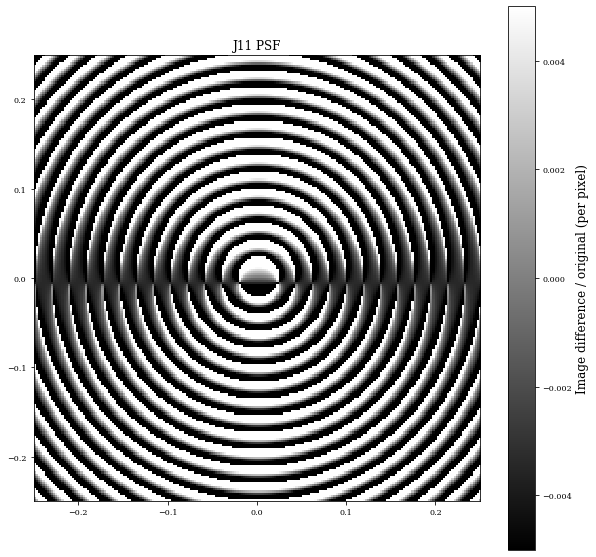

In [5]:
import matplotlib.pyplot as plot

plot.figure(figsize=[10,10])
poppy.display_psf_difference(psf_j11,psf_ref,title='J11 PSF',normalize_to_second=True,imagecrop=0.5,vmin=-5e-3,vmax=5e-3)
plot.show()